# AnyoneAI - Sprint Project 04
> Vehicle Classification

You've been learning a lot about Deep Learning Algorithms, now we you're gonna be asked to put it all together.


In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

True

In [2]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if IN_COLAB:
    # Put here the full path to the folder having your Sprint project code
    # e.g. "/content/drive/MyDrive/assignment"
    ROOT_DIR = "/content/drive/MyDrive/04_Sprint_Project"
    %cd $ROOT_DIR

/content/drive/MyDrive/04_Sprint_Project


In [4]:
%ls

'AnyoneAI - Sprint Project 04.ipynb'   logs/     README.md          tests/
 dataset/                              mlruns/   requirements.txt   TRAIN.ipynb
 docker/                               model/    src/


## Install dependencies (Only for Colab)

In [5]:
if IN_COLAB:
    # This will make sure you have installed all the proper dependencies
    # Instal dependencies
    !pip install -r requirements.txt
    # We can access to GPUs in Colab, so install GPU version of tensorflow
    !pip install tensorflow-gpu==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Introduction

This is a Multi-class Classification task: we want to predict, given a picture of a vehicle, which of the possible 25 classes is the correct vehicle make-model.

The dataset is composed of JPG images, already stored in folders containing the label (vehicle make-model), separated in train and test sets.


In [6]:
import os

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
from src import data_utils, models, config
from datetime import datetime


# Visualizing some basic training data and model performance metrics
import seaborn as sns
import pandas as pd

def plot_training(history, metric:str, axis=None):
  """
  Plot the training history for a specified metric.

  Args:
      history: The training history obtained from the model.
      metric (str): The metric to be plotted, can be "lr", "accuracy", or "loss".
      axis: The axis object for plotting the graph.

  Returns:
      The plot showing the training history for the specified metric.
  """

  if metric == "lr":
    lr = history.history["lr"]
    epoch = history.epoch
    ax1 = sns.lineplot(x=epoch,y=lr, ax=axis)
    ax1.legend(["Learning Rate"])
    ax1.set_title("Learning Rate Evolution")

  elif metric == "accuracy":
    train = history.history["accuracy"]
    val = history.history["val_accuracy"]
    epoch = history.epoch
    ax = sns.lineplot(x=epoch,y=train, ax=axis, label= "Train")
    ax = sns.lineplot(x=epoch,y=val, ax=axis, label = "Val")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy Evolution in traning")

  elif metric == "loss":
    train = history.history["loss"]
    val = history.history["val_loss"]
    epoch = history.epoch
    ax = sns.lineplot(x=epoch,y=train, ax=axis, label= "Train")
    ax = sns.lineplot(x=epoch,y=val, ax=axis, label = "Val")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("Loss Evolution in traning")
  else:
    return print("No valid metric")

def recreate_data_set(dataset):
  """
  Recreate a data set by concatenating batches and labels from
  datasets previously made from image_dataset_from_directory.

  Args:
      dataset: The input dataset containing batches and labels.

  Returns:
      The recreated data set with concatenated batches and labels.
  """
  i = 1
  for batch,label in dataset:
    if i == 1:
      test_images = tf.concat(batch,axis=0)
      test_labels = tf.concat(label, axis=0)
    else:
      test_images = tf.concat([batch,test_images],axis=0)
      test_labels = tf.concat([label, test_labels],axis=0)
    i += 1
  return test_images , test_labels

def get_best_prediction(data):
  """
  Get the best predictions from the given data.

  Args:
      data: The input data containing prediction values.

  Returns:
      The Top 1 prediction based on the maximum value along the prediction axis.
  """
  best_preds = tf.math.argmax(data,axis=1)
  return best_preds

def plot_class_distribution(preds,ax=None, cmap=None):
  """
  Plot the class distribution based on the predictions.

  Args:
      preds: The predicted classes.
      ax: The axis object for plotting the graph.
      cmap: The colormap for the countplot.

  Returns:
      The plot showing the class distribution based on the predictions.
  """
  ax  = sns.countplot(data = pd.DataFrame(preds),y=0,orient="h",ax=ax, cmap=cmap)
  return ax

def decode_prediction(preds,class_dict):
  """
  Decode the predicted classes using the provided class dictionary.

  Args:
      preds: The predicted classes.
      class_dict: A dictionary mapping class indices to their corresponding labels.

  Returns:
      The decoded predicted classes as a list of labels.
  """

  decoded = [class_dict[pred] for pred in preds]
  return decoded

def plot_confusion(y,y_pred,labels=None, axis=None):

  """
  Plot a confusion matrix based on the true labels and predicted labels.

  Args:
      y: The true labels.
      y_pred: The predicted labels.
      labels: A list of label names for the classes. If not provided, labels will be inferred from the unique values in y.
      axis: The axis object for plotting the graph.

  Returns:
      The plot showing the confusion matrix.
  """

  matrix = tf.math.confusion_matrix(y,y_pred)
  ax = sns.heatmap(matrix,annot=True,xticklabels=labels, yticklabels=labels, ax=axis, fmt="d", cmap='Blues')
  return ax

def plot_dual_pred_distribution(y,y_pred,ax=None):

  """
  Plot the dual prediction distribution for true labels and predicted labels.

  Args:
      y: The true labels.
      y_pred: The predicted labels.
      ax: The axis object for plotting the graph.

  Returns:
      The plot showing the dual prediction distribution.
  """

  fig, ax = plt.subplots(1,1, gridspec_kw = {"hspace":0.5}, figsize=(5, 10))
  ax = plt.subplot(1,1,1)
  label = ["Pred", "Test"]
  kwargs={"alpha" : 0.5, "label" : label[0]}
  ax = sns.countplot(data = pd.DataFrame(y_pred),y=0,orient="h", color="blue", **kwargs)
  kwargs={"alpha" : 0.5, "label" : label[1]}
  ax = sns.countplot(data = pd.DataFrame(y),y=0,orient="h", color="red", **kwargs)
  ax.set(title="Classes Distribution")
  plt.ylabel("Classes")
  plt.legend()

  return ax

### Getting the data

To access the data for this project, you only need to execute the code below. This will download a zip file `cars_25_dataset.zip` containing inside:

- `car_ims_dataset`: Folder whit train and test images, already classified in sub-folders with the corresponding vehicle label.

- `train_dataset_annos.csv` and `test_dataset_annos.csv`: Train and test images annotations provided in CSV file format. You will not need these files unless you want to solve the optional exercises.


1.1. Download the training and test datasets.

In [7]:
if IN_COLAB:
    config.DATASET_ROOT_PATH = "/content/drive/MyDrive/04_Sprint_Project/dataset"

data_utils.download_datasets(config.DATASET_ROOT_PATH)

1.2. Setup some variables you will use during training the model.

The default values used here should work fine for you.

In [8]:
# Dataset folder
DATASET_FOLDER = os.path.join(config.DATASET_ROOT_PATH, config.DATASET_FILENAME)
DATASET_FOLDER = os.path.join(config.DATASET_ROOT_PATH, "eu-car-dataset_subset")

img_height = 224
img_width = 224
batch_size = 32

1.3. Load the training and testing images as a Tensorflow dataset (`tf.data.Dataset`).

Note that it's not a good idea to load all the images into memory because they may need more RAM than the one installed in the system. This is why we create generators using the `image_dataset_from_directory()` function, which loads the images only when they are needed and then releases the memory for loading another batch of new images from the disk.


**Don't change anything in this cell, just make it run correctly**

In [9]:
# Load train and test datasets
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(DATASET_FOLDER, "train"),
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(DATASET_FOLDER, "test"),
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 7509 files belonging to 25 classes.
Found 1875 files belonging to 25 classes.


**Checkpoint:** The cell above should output the following message:

```code
Found 7509 files belonging to 25 classes.
Found 1875 files belonging to 25 classes.
```

## 2. Basic EDA

Let's load and display some pictures with their labels.


2.1. Take the class names automatically inferred from the data generator and assign to `class_names` variable. We will use this to do some EDA and also to define the output units in the classification layer of our model.


**Don't change anything in this cell, just make it run correctly**

In [10]:
class_names = train_ds.class_names
print(class_names)

assert len(class_names) == 25

['abarth_595-turismo', 'abarth_grande-punto', 'bmw_z4', 'citroen_c-crosser', 'citroen_ds4', 'citroen_nemo', 'dacia_lodgy', 'ford_f-150', 'hyundai_h-350', 'hyundai_i30', 'land-rover_range-rover-velar', 'mercedes-benz_180', 'mercedes-benz_a-180', 'mercedes-benz_b-220', 'mercedes-benz_cla-220', 'mercedes-benz_cls-320', 'mercedes-benz_slk-350', 'mini_cooper-sd', 'nissan_nv400', 'nissan_primastar', 'peugeot_108', 'porsche_991', 'suzuki_ignis', 'volkswagen_fox', 'volkswagen_up!']


2.2. Let's show some pictures!

You can re-run the following cell as many times as you want and it will always show a new set of images and labels.

**Don't change anything in this cell, just make it run correctly**

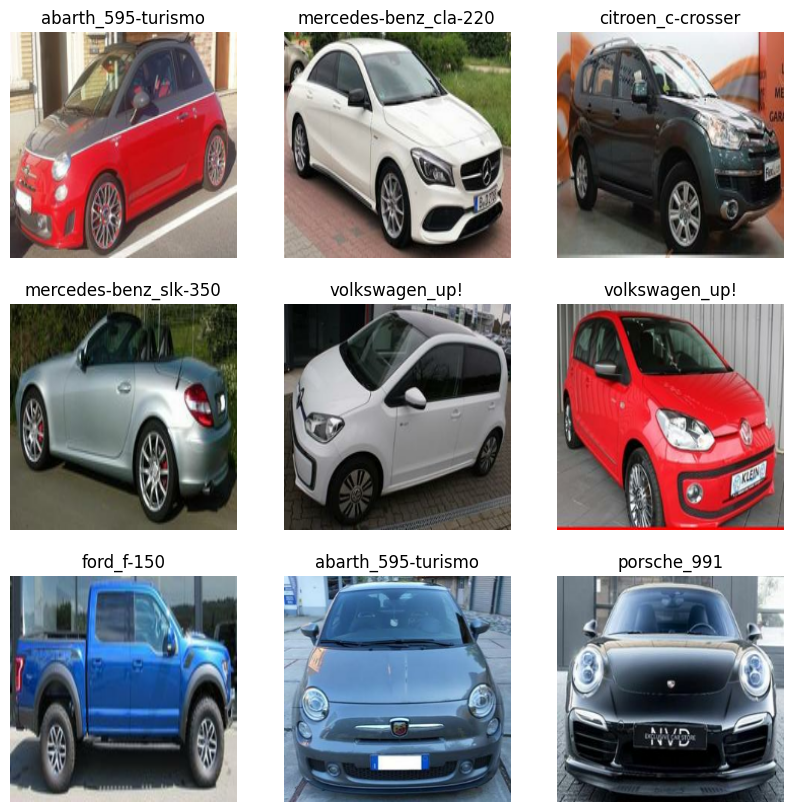

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

**Don't change anything in this cell, just make it run correctly**

In [12]:
# Configure data loader for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 3. Multi-layer Perceptron

*Now it's time to train our first Neural Network model. For simplicity, we are going to try using an MLP model.*

*A Multi-layer Perceptron (MLP) is a simple neural network consisting of multiple layers of nodes connected by weighted edges. The input and output layers have one node per feature, and one node per target class respectively, while the intermediate layers have an arbitrary number of nodes. MLPs are known to work well for simple classification tasks, but they might not be suitable for image classification, where the input data has a high dimensionality and there are correlations between adjacent pixels.*

---

Executing the following cell will create a model using the `create_mlp_model()` functions you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_mlp_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


In [ ]:
model_name = "mlp-clasifier-test"
now = datetime.now().strftime("%d_%m_%Y_%H%M%S")

# Creating an instance of the model based on src/models.py
mlp_model = models.create_mlp_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Defining metrics
metrics = ["accuracy"]

# Compile the model
mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss="categorical_crossentropy",
    metrics=metrics,
)

# Setting the directories for callbacks
log_dir = f"./logs/{model_name}-" + now
model_path = f"./model/{model_name}-" + now + ".h5"
checkpoint_filepath = model_path

# Callbacks
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        patience=2,
        factor=0.1,
        min_lr=0
        )
]

# Fitting the model
history = mlp_model.fit(
    train_ds,
    epochs=20,
    validation_data = test_ds,
    callbacks=my_callbacks,
    verbose =1
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 512)               77070848  
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 25)                12825     
                                                                 
Total params: 78,133,785
Trainable params: 78,133,785
No

At this point the model accuracy in the validation dataset should be around *0.3*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

**Answer**

The model's overfitting issue is evident, as indicated by the significant gap between its test accuracy of +0.75 and validation accuracy of 0.3. Even though the test accuracy is low, training for more epochs will likely produce 80+ or 90+ in accuracy in the training data as the model is clearly learning the patterns in the test data but is not fitted for new data.

To address overfitting and enhance the model's performance, we can consider implementing the following changes:

Increase the amount of training data: By expanding the training dataset with a larger and more diverse set of samples, the model can better learn generalized patterns and reduce overfitting.

Regularization techniques: Employ regularization techniques such as L1 or L2 regularization on specific layers of the model, utilize dropout to randomly deactivate certain neurons during training, or implement early stopping to halt training when the model's performance on the validation set plateaus.

Adjust model complexity: If the model is excessively complex, it may possess an increased potential for overfitting. Reducing the model's complexity can be attempted by reducing the number of layers, decreasing the number of hidden units, or opting for a simpler model architecture altogether.

In [ ]:
images , labels = recreate_data_set(test_ds)
labels_test= get_best_prediction(labels)
decoded_test = decode_prediction(labels_test,class_names)

labels_pred = mlp_model.predict(images)
labels_pred = get_best_prediction(labels_pred)
decoded_pred = decode_prediction(labels_pred,class_names)

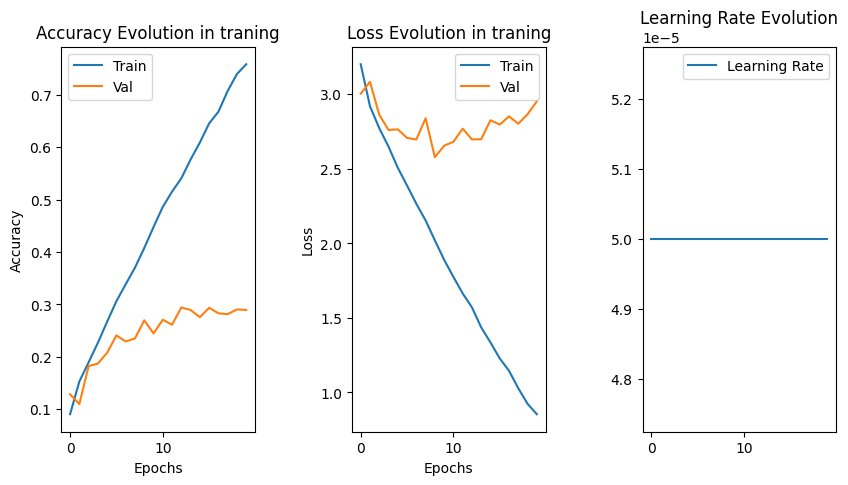

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5), gridspec_kw={"wspace": 0.5 , "hspace": 0.5})
plot_training(history,"accuracy",ax[0])
plot_training(history,"loss",ax[1])
plot_training(history,"lr", ax[2])

<Axes: >

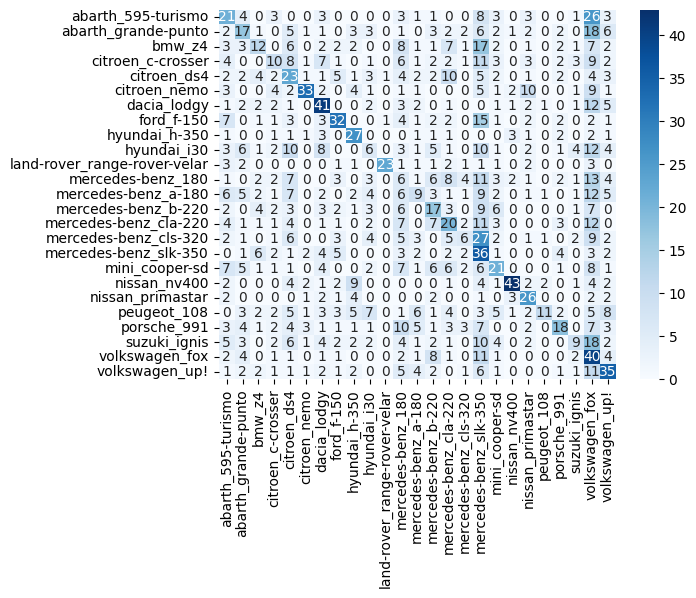

In [ ]:
plot_confusion(labels_test,labels_pred,class_names)

<Axes: title={'center': 'Test Distribution'}, xlabel='count', ylabel='Classes'>

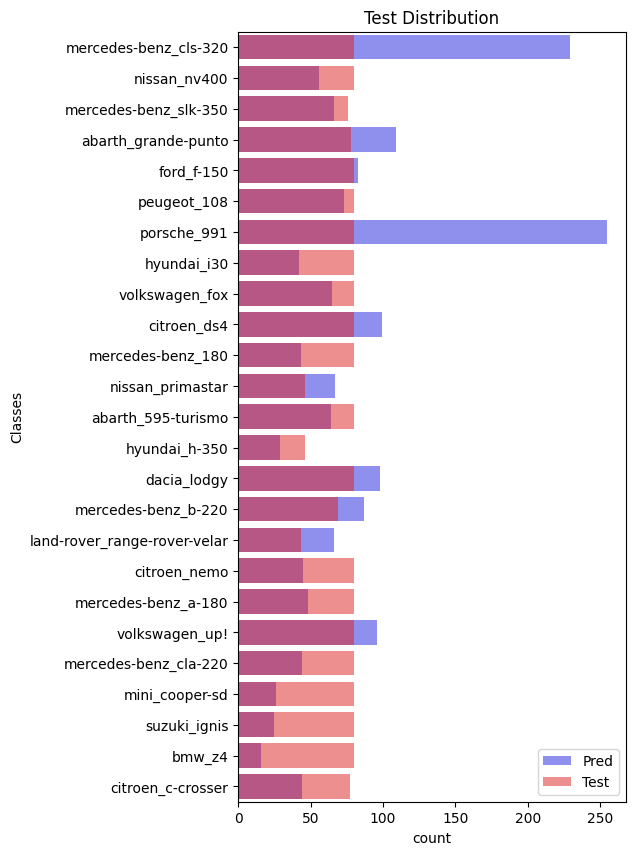

In [ ]:
plot_dual_pred_distribution(decoded_test,decoded_pred)

## 4. CNN: LeNet

*Multi-layer Perceptrons are known to work well for simple classification tasks, but they might not be suitable for image classification, where the input data has a high dimensionality and there are correlations between adjacent pixels.*

*If the previous model wasn't enough for the accuracy we aim to achieve, we can try a bigger one, a Convolutional Network! We are going to use the first develop CNN, the LeNet model.*

*LeNet is a type of Convolutional Neural Network (CNN) that was specifically designed for image classification. LeNet uses a set of convolutional layers to extract low-level features such as edges and corners, and then combines them into higher-level features through a series of pooling layers. Finally, a set of fully connected layers is used to classify the images. LeNet has shown to be very effective in image classification tasks, especially in cases where the input images are small and the features are not too complex.*

---

Executing the following cell will create a model using the `create_lenet_model()` function you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_lenet_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


In [ ]:
model_name = "lenet-clasifier"
now = datetime.now().strftime("%d_%m_%Y_%H%M%S")


# Creating an instance of Lenet based on ./src/models.py
lenet_model = models.create_lenet_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Metrics
metrics = ["accuracy"]

# Compile the model
lenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss="categorical_crossentropy",
    metrics=metrics,
)

# Setting directories for callbacks
log_dir = f"./logs/{model_name}-" + now
model_path = f"./model/{model_name}-" + now + ".h5"
checkpoint_filepath = model_path

# Defining Callbacks
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        patience=2,
        factor=0.1,
        min_lr=0
        ),
    tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
        )
]

# Fitting the model
history = lenet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=my_callbacks,
    verbose =1
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 average_pooling2d (AverageP  (None, 111, 111, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 average_pooling2d_1 (Averag  (None, 54, 54, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 46656)            

In [ ]:
images , labels = recreate_data_set(test_ds)
labels_test= get_best_prediction(labels)
decoded_test = decode_prediction(labels_test,class_names)

labels_pred = mlp_model.predict(images)
labels_pred = get_best_prediction(labels_pred)
decoded_pred = decode_prediction(labels_pred,class_names)

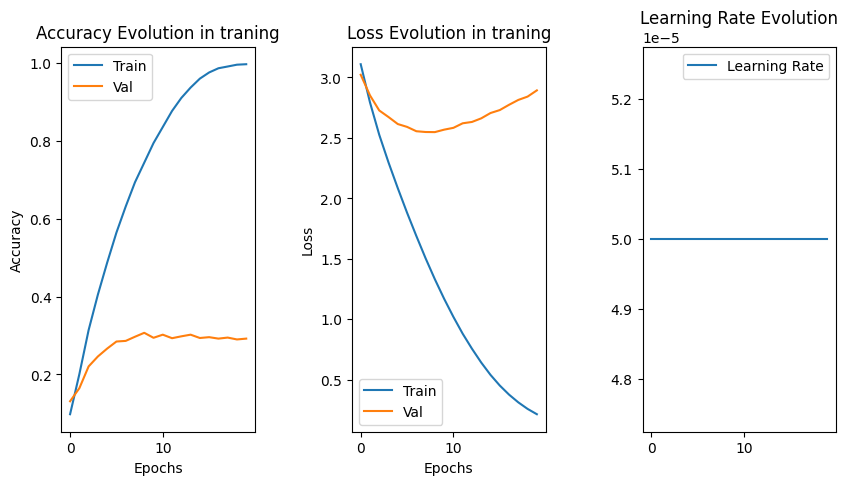

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5), gridspec_kw={"wspace": 0.5 , "hspace": 0.5})
plot_training(history,"accuracy",ax[0])
plot_training(history,"loss",ax[1])
plot_training(history,"lr", ax[2])


<Axes: >

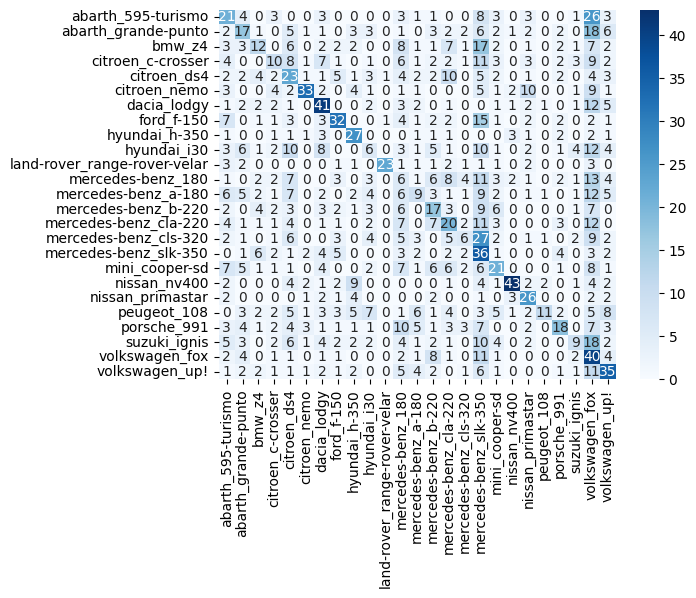

In [ ]:
plot_confusion(labels_test,labels_pred,class_names)

<Axes: title={'center': 'Classes Distribution'}, xlabel='count', ylabel='Classes'>

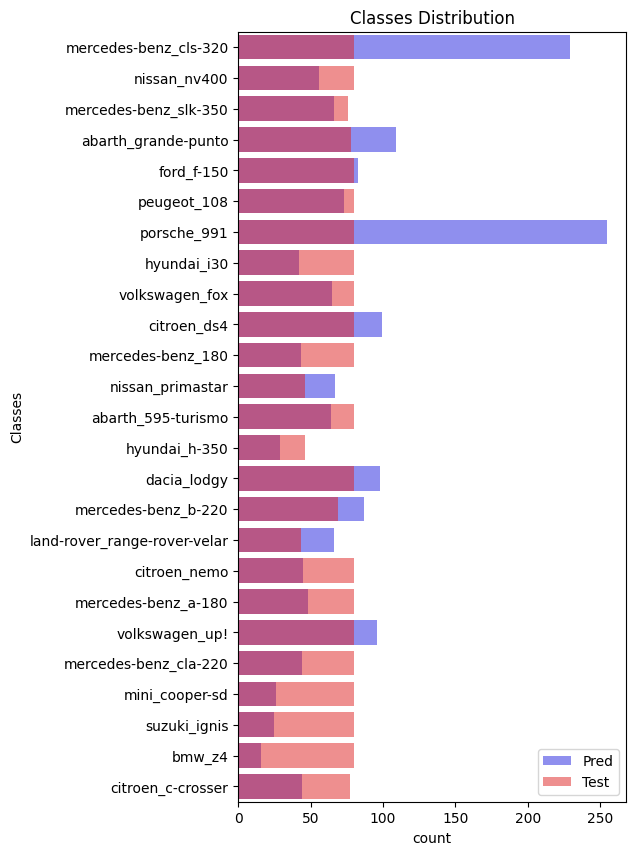

In [ ]:
plot_dual_pred_distribution(decoded_test,decoded_pred)

At this point the model accuracy in the validation dataset should be around *0.3*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

**Answer**

The model's overfitting issue is evident, as indicated by the significant gap between its test accuracy of **+0.95** and validation accuracy of **0.3**.

To address overfitting and enhance the model's performance, we can consider implementing the following changes:

Increase the amount of training data: By expanding the training dataset with a larger and more diverse set of samples, the model can better learn generalized patterns and reduce overfitting.

Regularization techniques: Employ regularization techniques such as L1 or L2 regularization on specific layers of the model, utilize dropout to randomly deactivate certain neurons during training, or implement early stopping to halt training when the model's performance on the validation set plateaus.

Adjust model complexity: If the model is excessively complex, it may possess an increased potential for overfitting. Reducing the model's complexity can be attempted by reducing the number of layers, decreasing the number of hidden units, or opting for a simpler model architecture altogether.

## 5. CNN: Transfer learning from ResNet50

*Maybe the LeNet is still no the best choice for our task. Actually, most of the time, when solving image classification problems, the best results are achieved using pre-built CNN architecture pre-trained on imagenet dataset. This process is commonly known as **transfer learning** or **fine-tuning**.*

*ResNet50, is a much deeper CNN that was developed to tackle the problem of vanishing gradients in deep neural networks. ResNet50 is made up of many layers that are organized into blocks, each of which has a set of convolutional layers followed by shortcut connections that allow for the easy flow of information between layers. These shortcut connections help to prevent vanishing gradients and allow the network to learn very deep representations of the input images. This makes ResNet50 ideal for image classification tasks where the input images are complex and large.*

*Therefore, it would be better to use ResNet50 finetuning for image classification tasks, especially if the input images are complex and large, as it has been optimized for this specific task and has shown to be very effective in achieving state-of-the-art results. Additionally, using ResNet50 finetuning means that the model can take advantage of the pre-trained weights on a large dataset, which can lead to faster convergence and better performance on smaller datasets.*

---

Executing the following cell will create a model using the `create_resnet50_model()` function you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_resnet50_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


In [ ]:
model_name = "resnet50-clasifier"
now = datetime.now().strftime("%d_%m_%Y_%H%M%S")


# Creating resnet50 from ./src/models.py
resnet50_model = models.create_resnet50_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
resnet50_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=metrics,
)

# Metrics
metrics = ["accuracy"]

# Setting directories for callbacks
log_dir = f"./logs/{model_name}-" + now
model_path = f"./model/{model_name}-" + now + ".h5"
checkpoint_filepath = model_path

# Callbacks
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        patience=2,
        factor=0.1,
        min_lr=0
        ),
    tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
        )
]

# Fitting the model
history = resnet50_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=my_callbacks,
    verbose =1
)

94781440/94765736 [==============================] - 4s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 25)                2508825   
                                                                 
Total params: 26,096,537
Trainable params: 2,508,825
Non-trainable params: 23,587,712
_________________________________________________________________
None
Epoch 1/20
235/235 [==============================] - 48s 183ms/step - loss: 3.3421 - accuracy: 

In [ ]:
images , labels = recreate_data_set(test_ds)
labels_test= get_best_prediction(labels)
decoded_test = decode_prediction(labels_test,class_names)

labels_pred = mlp_model.predict(images)
labels_pred = get_best_prediction(labels_pred)
decoded_pred = decode_prediction(labels_pred,class_names)

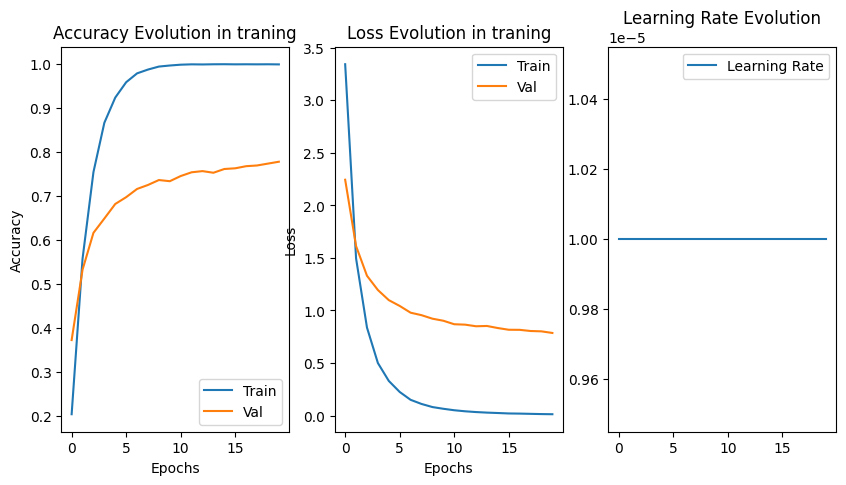

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5), gridspec_kw={"wspace": 0.5 , "hspace": 0.5})
plot_training(history,"accuracy",ax[0])
plot_training(history,"loss",ax[1])
plot_training(history,"lr", ax[2])

<Axes: >

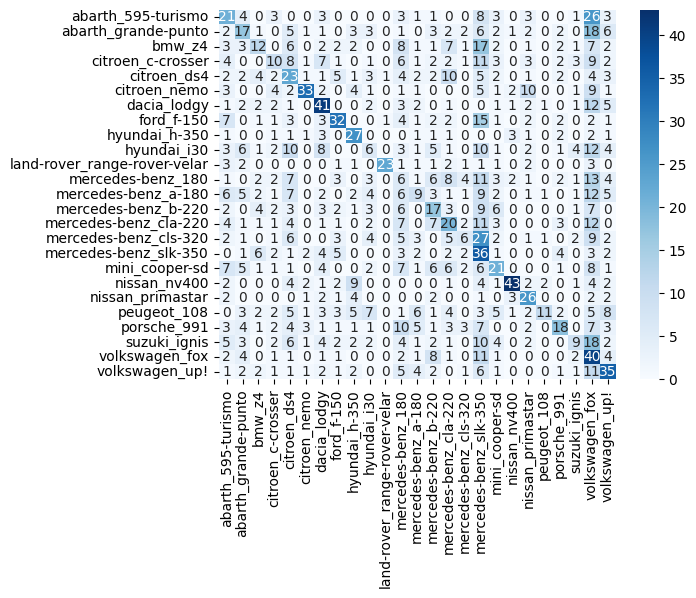

In [ ]:
plot_confusion(labels_test,labels_pred,class_names)

<Axes: title={'center': 'Classes Distribution'}, xlabel='count', ylabel='Classes'>

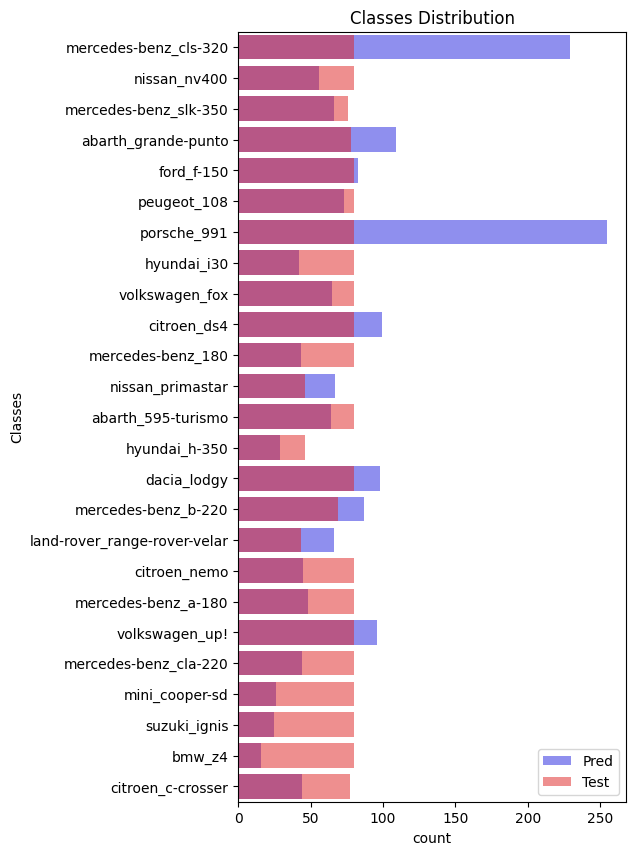

In [ ]:
plot_dual_pred_distribution(decoded_test,decoded_pred)

At this point the model accuracy in the validation dataset should be around *0.7*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

**Answer**

The model is clearly overfitted. Reaching *+0.95* vs *0.7* in the test/val relationship.

To address overfitting and improve the model's performance, we can consider several changes:

Increase the amount of training data: A larger and more diverse dataset can help the model learn more generalized patterns and reduce overfitting.

Regularization techniques: Apply regularization techniques like L1 or L2 regularization to some of the layers, dropout, or early stopping. 

Adjust model complexity: If the model is too complex, it may have more capacity to overfit. We can try reducing the model's complexity by reducing the number of layers, hidden units, or using a simpler model architecture.

## 6. Analyze model results

Choose your best model and report some metrics on the results you obtained.

You can plot a confussion matrix or use [Scikit-learn classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).


In [ ]:
# Printing classification report
report = classification_report(labels_test,labels_pred,target_names = class_names)
print(report)

                              precision    recall  f1-score   support

          abarth_595-turismo       0.24      0.26      0.25        80
         abarth_grande-punto       0.26      0.22      0.24        78
                      bmw_z4       0.29      0.15      0.20        80
           citroen_c-crosser       0.23      0.13      0.17        77
                 citroen_ds4       0.21      0.29      0.24        80
                citroen_nemo       0.69      0.41      0.52        80
                 dacia_lodgy       0.41      0.51      0.46        80
                  ford_f-150       0.48      0.40      0.44        80
               hyundai_h-350       0.42      0.59      0.49        46
                 hyundai_i30       0.14      0.07      0.10        80
land-rover_range-rover-velar       0.92      0.53      0.68        43
           mercedes-benz_180       0.06      0.07      0.07        80
         mercedes-benz_a-180       0.20      0.11      0.14        80
         mercedes-b

## 7. Optional. Make your own model

The models we've trained before are just a limited set over the universe of stuff you can use.

You still have a lot of things to experiment with to increase accuracy, some ideas are:

1. Use any other CNN architecture you think may perform better than ResNet50.
2. Try adding data augmentation or any other regularization algorithms.
3. Train using more epochs, a different optimization algorithm, etc.
4. Check [KerasTuner](https://keras.io/api/keras_tuner/) documentation about how to efficiently test a lot of different architectures and parameters.


# Eval Accuracy in the different models trained
<img src="images/evaluation_accuracy_vs_iterations.svg" alt= “” width="500" height="500">


In [18]:
from tensorflow.keras.applications.efficientnet import EfficientNetB2, decode_predictions
from tensorflow.keras.layers import (
    Flatten,
    Dense,
    Dropout,
    RandomFlip,
    RandomRotation,
    RandomZoom,
    RandomContrast,
    GlobalAveragePooling2D
)
from tensorflow.keras import regularizers
from tensorflow.python.ops.math_ops import Max
from tensorflow.python.ops.nn_ops import MaxPool

def create_efficientnetv2b2_model(input_shape, num_classes):
  """
  Create an EfficientNetV2B2 model with additional layers for classification.

  Args:
      input_shape: The shape of the input image tensor.
      num_classes: The number of classes for classification.

  Returns:
      The created EfficientNetB2 model.
  """

  inputs = keras.Input(shape=input_shape)

  # Create data agumentation sequence
  # data_augmentation = keras.Sequential(
  # [
  #     RandomFlip("horizontal", seed=0),
  #     RandomRotation(0.3,seed=0, fill_mode="nearest",
  #   interpolation="nearest"),
  #     RandomContrast(0.5, seed=0),
  # ]
  # )

  # Apply Data augmentation on input images

  #x = data_augmentation(inputs, training=True)

  model = EfficientNetB2(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    pooling=None,
  )
  model.trainable = False

  # Add the pre-trained model here
  x = model(inputs)
  x = GlobalAveragePooling2D()(x)
  # Add new layers
  # x = Flatten()(x)
  x = Dropout(0.2)(x)

  outputs = Dense(num_classes, activation="softmax")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  print(model.summary())

  return model

In [19]:
model_name = "efficientnetv2b2-clasifier"
now = datetime.now().strftime("%d_%m_%Y_%H%M%S")

# Creating an instance of EfficientnetV2
efficientv2b2_model = create_efficientnetv2b2_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Metrics
metrics = ["accuracy"]

#Compile the model
efficientv2b2_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-1),
    loss="categorical_crossentropy",
    metrics=metrics,
)

# Settings callbacks directories
log_dir = f"./logs/{model_name}-" + now
model_path = f"./model/{model_name}-" + now + ".h5"
checkpoint_filepath = model_path

# Callbacks
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        patience=2,
        factor=0.1,
        min_lr=0
        ),
    tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
        )
]

# Fitting
history = efficientv2b2_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=100,
    callbacks=my_callbacks,
    verbose =1
)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 global_average_pooling2d_1   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1408)              0         
                                                                 
 dense_1 (Dense)             (None, 25)                35225     
                                                                 
Total params: 7,803,794
Trainable params: 35,225
Non-trainable params: 7,768,569
____________________________________________

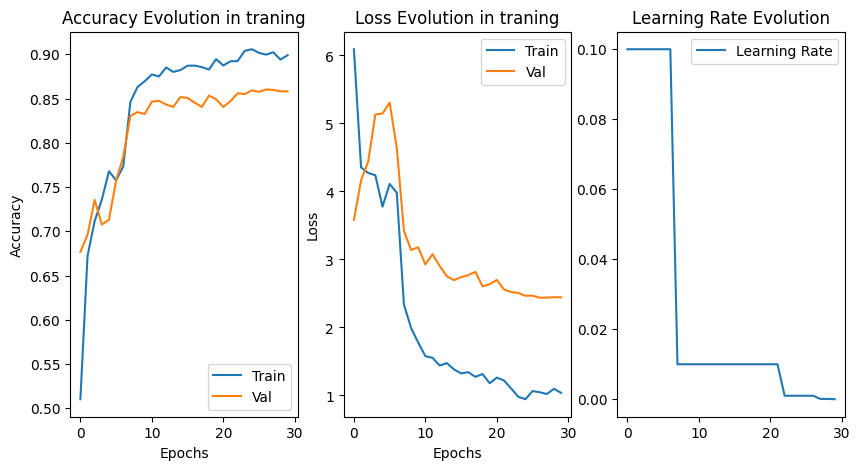

In [21]:
images , labels = recreate_data_set(test_ds)
labels_test= get_best_prediction(labels)
decoded_test = decode_prediction(labels_test,class_names)

labels_pred = efficientv2b2_model.predict(images)
labels_pred = get_best_prediction(labels_pred)
decoded_pred = decode_prediction(labels_pred,class_names)

fig, ax = plt.subplots(1,3, figsize=(10,5))
plot_training(history,"accuracy",ax[0])
plot_training(history,"loss",ax[1])
plot_training(history,"lr",ax[2])

<Axes: >

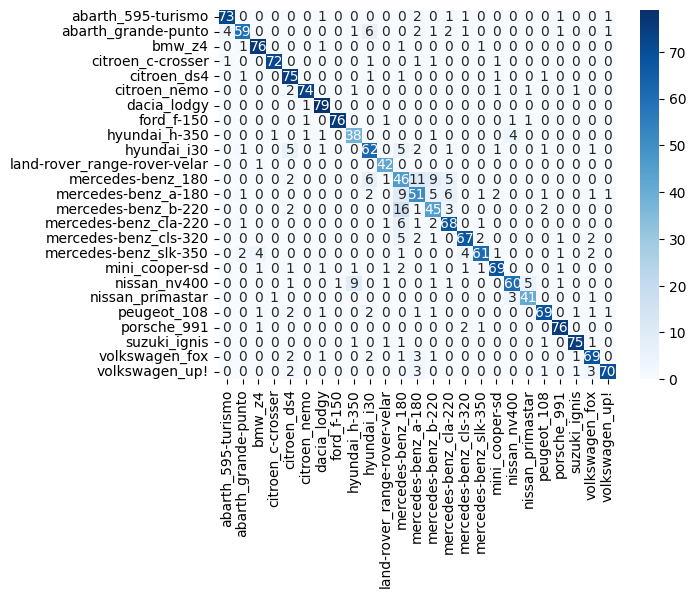

In [20]:
plot_confusion(labels_test,labels_pred,class_names)

In [17]:
report = classification_report(labels_test,labels_pred,target_names = class_names)
print(report)

                              precision    recall  f1-score   support

          abarth_595-turismo       0.94      0.91      0.92        80
         abarth_grande-punto       0.89      0.76      0.82        78
                      bmw_z4       0.90      0.95      0.93        80
           citroen_c-crosser       0.97      0.94      0.95        77
                 citroen_ds4       0.80      0.94      0.86        80
                citroen_nemo       0.96      0.93      0.94        80
                 dacia_lodgy       0.92      0.99      0.95        80
                  ford_f-150       0.99      0.95      0.97        80
               hyundai_h-350       0.75      0.83      0.78        46
                 hyundai_i30       0.76      0.78      0.77        80
land-rover_range-rover-velar       0.88      0.98      0.92        43
           mercedes-benz_180       0.49      0.57      0.53        80
         mercedes-benz_a-180       0.64      0.64      0.64        80
         mercedes-b